In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy
from shapely.geometry import point

In [3]:
os.getcwd()

'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning'

In [141]:
#loading in the current enrollment for only the 2024-25 school year
current_enrollment = pd.read_csv(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\marketshare_output_pu_2324_848_gr_2021_2425_long.csv')
current_enrollment_2024 = current_enrollment[current_enrollment['year_str']=='2024-2025']
current_enrollment_2024.head()
current_enrollment_2024 = current_enrollment_2024.rename(columns = {'pu_2324_848':'pu_2324_84'})

In [169]:
#now we want to only show the 5th, 6th, 7th, and 8th grade - the grades that will be in high school in 2028-29
mask = current_enrollment_2024['grade'].isin([5,6,7,8])
hs_2028 = current_enrollment_2024[mask]
hs_2028 = hs_2028[['pu_2324_84','count','basez','lottery']]

In [170]:
#merging identical rows to get student counts by block and grade
columns_to_group = ['pu_2324_84']
hs_2028 = hs_2028.groupby(columns_to_group,as_index=False).sum() #as_index=False preserves the columns we are grouping by

#the planning units with zero enrollment are missing, so we must fill them with zeros
all_pus = pd.DataFrame({'pu_2324_84': range(1,849)})
hs_2028_full = all_pus.merge(hs_2028, on='pu_2324_84',how='left').fillna(0)
hs_2028_full

,pu_2324_84,count,basez,lottery
0,1,1.0,0.0,1.0
1,2,9.0,4.0,4.0
2,3,2.0,2.0,0.0
3,4,2.0,1.0,1.0
4,5,8.0,6.0,1.0
...,...,...,...,...
843,844,6.0,5.0,0.0
844,845,15.0,12.0,2.0
845,846,0.0,0.0,0.0
846,847,1.0,1.0,0.0


In [199]:
#read in the planning units and their centroids
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\PU_2425_918\\PU_2425_918.shp').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu['centroid'] = dps_pu['geometry'].centroid
dps_pu
#WHY IS THERE 918 ROWS??

,OBJECTID,pu_2324_84,X,Y,TIMS_PU,pu_2425_91,Join_Count,TARGET_FID,Join_Cou_1,TARGET_F_1,...,sch_id_g_2,choice_hs,type_hs,region_202,region_2_1,pu_2425__2,Shape_Leng,Shape_Area,geometry,centroid
0,1.0,1,2.049028e+06,893128.606346,PU589,1,1,1,1,1,...,356,None,High School Base Assignment Zone,North,North,820,26532.120021,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+...",POINT (-8.78e+06 4.33e+06)
1,2.0,2,2.039923e+06,835434.121317,PU401,2,1,2,1,2,...,356,None,High School Base Assignment Zone,North,North,664,19333.085511,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+...",POINT (-8.78e+06 4.31e+06)
2,3.0,3,2.058005e+06,797649.028742,PU782.0,3,1,3,1,3,...,368,Energy & Sustainability,High School Base Assignment Zone,East,East,1,18314.823119,1.329077e+07,"POLYGON ((-8.77e+06 4.29e+06, -8.77e+06 4.29e+...",POINT (-8.77e+06 4.29e+06)
3,4.0,4,2.003222e+06,772895.737307,PU201.0,4,1,4,1,4,...,312,None,High School Base Assignment Zone,Southwest,Southwest,404,29282.100083,4.684140e+07,"POLYGON ((-8.79e+06 4.29e+06, -8.79e+06 4.29e+...",POINT (-8.79e+06 4.28e+06)
4,5.0,5,2.067334e+06,828244.230730,PU646,5,1,5,1,5,...,368,Energy & Sustainability,High School Base Assignment Zone,East,East,133,60685.151474,1.497046e+08,"POLYGON ((-8.77e+06 4.3e+06, -8.77e+06 4.3e+06...",POINT (-8.77e+06 4.3e+06)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,839.0,844,2.011851e+06,824885.632280,PU468,839,1,839,1,839,...,365,None,High School Base Assignment Zone,Southwest,Southwest,475,6419.265826,2.254156e+06,"POLYGON ((-8.79e+06 4.3e+06, -8.79e+06 4.3e+06...",POINT (-8.79e+06 4.3e+06)
839,840.0,845,2.018359e+06,853286.849340,PU329,840,1,840,1,840,...,356,None,High School Base Assignment Zone,North,North,816,15620.191583,1.246839e+07,"POLYGON ((-8.79e+06 4.31e+06, -8.79e+06 4.31e+...",POINT (-8.79e+06 4.31e+06)
840,841.0,846,2.016360e+06,858711.587472,PU573,841,1,841,1,841,...,356,None,High School Base Assignment Zone,North,North,817,16660.241935,9.218197e+06,"POLYGON ((-8.79e+06 4.32e+06, -8.79e+06 4.32e+...",POINT (-8.79e+06 4.32e+06)
841,842.0,847,2.013328e+06,854621.040074,PU322,842,1,842,1,842,...,356,None,High School Base Assignment Zone,North,North,818,9379.857191,3.748151e+06,"POLYGON ((-8.79e+06 4.31e+06, -8.79e+06 4.31e+...",POINT (-8.79e+06 4.31e+06)


In [182]:
#read in the school locations
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs

,OBJECTID,facilityid,sch_id6,sch_id,name,address,phone,agencyurl,operhours,spectype,...,region_base,region_physical,calendar_2324,calendar_2425,choice_2324,choice_2425,choice_2526,x_ncplane,y_ncplane,geometry
10,11,27253,320368,368,Southern High School,"800 Clayton Road Durham, NC 27703",919-560-3968,http://southern.dpsnc.net/pages/Southern_High,9:15am - 4:15pm,Magnet School,...,east,east,Traditional,Traditional,Energy & Sustainability,Energy & Sustainability,Energy & Sustainability,2050552.39,818903.23,POINT (-8.78e+06 4.3e+06)
14,15,87951,320325,325,Hillside High School,3727 Fayetteville Street Durham NC 27707,919-560-3925,http://hillside.dpsnc.net/pages/Hillside_High,9:15am - 4:15pm,None,...,southeast,southeast,Traditional,Traditional,International Baccalaureate,International Baccalaureate,International Baccalaureate,2028531.50,801909.91,POINT (-8.78e+06 4.29e+06)
55,56,6494,320356,356,Northern High School,4622 N Roxboro Road Durham NC 27712,919-560-3956,http://northern.dpsnc.net/pages/Northern_High,9:15am - 4:15pm,None,...,north,north,Traditional,Traditional,None,None,None,2029463.13,841220.63,POINT (-8.78e+06 4.31e+06)
56,57,12065,320365,365,Riverside High School,"3218 Rose of Sharon Road Durham, NC 27712",919-560-3965,http://www.edlinesites.net/pages/Riverside_High,9:15am - 4:15pm,None,...,central,north,Traditional,Traditional,None,None,None,2018531.26,843582.30,POINT (-8.79e+06 4.31e+06)
57,58,76194,320312,312,Jordan High School,6806 Garrett Road Durham NC 27707,919-560-3912,http://jordan.dpsnc.net/pages/Jordan_High,9:15am - 4:15pm,None,...,southwest,southwest,Traditional,Traditional,None,None,None,2011193.93,790759.00,POINT (-8.79e+06 4.29e+06)


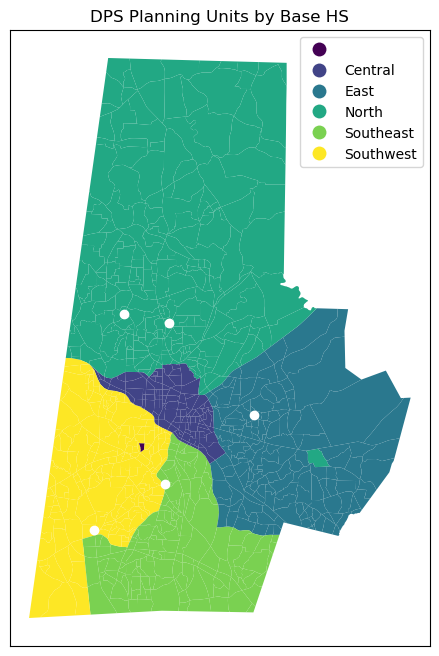

In [189]:
fig,ax = plt.subplots(figsize=(6,8))

dps_pu.plot(
    column = 'Region',
    legend = True,
    cmap = 'viridis',
    ax = ax
)
dps_base_hs.plot(ax=plt.gca(),zorder = 1, color = 'white')


ax.set_xticks([])
ax.set_yticks([])


plt.title('DPS Planning Units by Base HS')
plt.show()

In [200]:
hs_2028_geo_by_pu = dps_pu.merge(hs_2028_by_pu, on = 'pu_2324_84') #merge the student counts with the geometries

<Axes: >

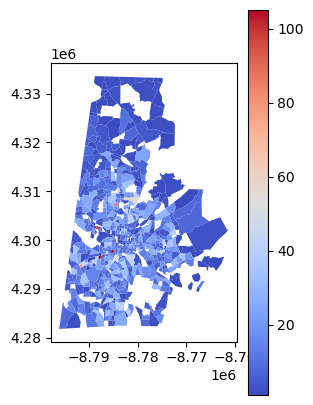

In [201]:
fig,ax = plt.subplots(figsize = (3,5))

hs_2028_geo_by_pu.plot(
    column = 'count',
    cmap = 'coolwarm',
    ax = ax,
    legend = True
)

In [ ]:
#considering changing marketshare from ms to hs

In [130]:
#building iterative boundary assigment


for j,unit in enumerate(hs_2028_geo_by_pu['pu_2324_84']):
    for i,hs in enumerate(dps_base_hs['name']):
        distance = dps_base_hs.iloc[i,28].distance(hs_2028_geo_by_pu.loc[j,'centroid'])
        hs_2028_geo_by_pu.loc[j,hs] = distance
        


hs_2028_geo_by_pu.head(2)



#assign high school based on distance next

,OBJECTID,pu_2324_84,X,Y,TIMS_PU,pu_2425_91,Join_Count,TARGET_FID,Join_Cou_1,TARGET_F_1,...,geometry,centroid,count,basez,lottery,Southern High School,Hillside High School,Northern High School,Riverside High School,Jordan High School
0,1.0,1,2.049028e+06,893128.606346,PU589,1,1,1,1,1,...,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+...",POINT (-8.78e+06 4.33e+06),1.0,0.0,1.0,28096.799821,35365.646970,20990.321930,22001.290024,41262.838649
1,2.0,2,2.039923e+06,835434.121317,PU401,2,1,2,1,2,...,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+...",POINT (-8.78e+06 4.31e+06),9.0,4.0,4.0,7420.115356,13376.571143,4507.345598,8626.692122,20047.006101
